# Test problem from Caroe et al. (1999)

$$
\begin{align*}
\max_{x}      \quad & \frac{3}{2} x_1 + 4 x_2 + Q(x_1, x_2) \\
\mathrm{s.t.} \quad & 0 \leq x \leq 5 \\
                    & x \ \mathrm{integer}
\end{align*}
$$

where $Q(x_1,x_2)$:
$$
\begin{align*}
\max_{y}      \quad & 16 y_1 + 19 y_2 + 23 y_3 + 28 y_4 \\
\mathrm{s.t.} \quad & 2 y_1 + 3 y_2 + 4 y_3 + 5 y_4 \leq \zeta_1 - x_1 \\
                    & 6 y_1 + y_2 + 3 y_3 + 2 y_4 \leq \zeta_2 - x_2 \\
                    & y_i \in \{0,1\}
\end{align*}
$$
and $\zeta = (\zeta_1,\zeta_2)$ is uniformly distributed on
$$\Pi = \{(5,5), (5,6),\dots,(5,15),(6,5),\dots,(15,15)\}$$
giving 121 scenarios.

In [1]:
RELAX_LP = False

In [5]:
from __future__ import division
from cobra import Model
from dynamicme.optimize import Variable, Constraint
from six import iteritems
from dynamicme.decomposition.LagrangeMaster import LagrangeMaster
from dynamicme.decomposition.LagrangeSubmodel import LagrangeSubmodel


import numpy as np
import pandas as pd

In [6]:
zetas = [(i,j) for i in np.arange(5,16) for j in np.arange(5,16)]
print('Scenarios: %s'%len(zetas))

Scenarios: 121


In [7]:
cx = -np.array([3/2, 4])
fy = -np.array([16, 19, 23, 28])
xl = [0, 0]
xu = [5, 5]
A  = [[2,3,4,5],
      [6,1,3,2]]

sub_dict = {}
for k,zeta in enumerate(zetas):
    mdl = Model('sub')    
    ys  = [Variable('y_%d'%j, lower_bound=0, upper_bound=1, objective_coefficient=fy[j]) for j in range(len(fy))]
    xs  = [Variable('x_%d'%j, lower_bound=xl[j], upper_bound=xu[j], objective_coefficient=cx[j]) for j in range(len(cx))]
    for x in xs:
        x.variable_kind = 'integer'
    for y in ys:
        y.variable_kind = 'integer'
    mdl.add_reactions(xs+ys)
    for i,ai in enumerate(A):
        cons = Constraint('cons_%d'%i)
        cons._constraint_sense = 'L'
        cons._bound = zeta[i]
        xs[i].add_metabolites({cons:1})
        for j,aij in enumerate(ai):
            ys[j].add_metabolites({cons:aij})
    sub_id = 'scen_%d'%k
    sub = LagrangeSubmodel(mdl, sub_id, first_stage_vars=xs)
    sub._weight = 1./len(zetas)
    sub_dict[sub_id] = sub

In [8]:
master = LagrangeMaster(mdl, first_stage_vars=xs)
master._INF = 1e8
master.add_submodels(sub_dict)
master._z.LB = -master._INF
master._z.UB = master._INF
master.model.Params.Presolve = 0
master.model.update()
master.model.Params.NodefileStart = 3.
for sub in sub_dict.values():
    sub.model.Params.NodefileStart = 3.

In [9]:
master.gaptol = 1e-3
master.penaltytol = 1e-6 #1e-4
master.delta_mult = 0.5
master.delta_min = 0
master.bundle_mult = 0.1

feasible_methods = ['heuristic','enumerate']
alt_method = 'pool'
max_alt = 10


if RELAX_LP:
    master.verbosity=2
    master.max_iter = 100
    sol_master = master.solve_relaxed(feasible_methods=None)
    df_phase1 = pd.DataFrame(master.log_rows)

master.gaptol = 0.01
master.verbosity=1
master.max_iter = 100
master.max_max_alt = 100
sol_master = master.optimize(feasible_methods=feasible_methods, max_alt=max_alt, alt_method=alt_method,
                             early_heuristics=['average']) 
df_phase2 = pd.DataFrame(master.log_rows)

    Iter                    UB                    LB       gap relgap(%)   penalty                       Time(s)
  ------   -------------------   -------------------  -------- ---------  -------- -----------------------------
               Dual   Feasible        Sub       Best                                   total    master       sub
       0     -56.28     -56.28     -70.58     -70.58      14.3      25.4         0  0.239263  0.001464  0.129936
      10      -63.6     -56.28     -66.51     -65.24     1.649     2.593     0.372  2.407781  0.015098  0.104748
      15     -64.15     -56.28     -64.15     -64.15 3.677e-06 5.732e-06  4.13e-08  3.621912  0.048041  0.159758
Unknown heuristic: heuristic
Feasible solution not among alt opt. Trying next iteration.
      16     -64.15     -62.29     -64.15     -64.15         0         0  4.72e-11  73.08630  0.038386  0.245069
Unknown heuristic: heuristic
Feasible solution not among alt opt. Trying next iteration.
Master ascent of 6.75355181556e

In [10]:
master._z.X

-64.14765819907188

In [11]:
master.solve_lagrangian(master.uopt)

-64.14765842628384

In [12]:
df_phase2

,LB,bestLB,bestUB,delta,feasUB,gap,iter,relgap,res_u,t_master,t_sub,t_total
0,-70.578512,-70.578512,-56.280992,1.000000,-56.280992,14.297521,0,25.403818,0.000000e+00,0.001465,0.129937,0.163647
1,-70.519637,-70.519637,-70.519636,0.500000,-56.280992,0.000000,1,0.000000,2.943788e-02,0.003267,0.094255,0.377563
2,-70.401885,-70.401885,-70.401886,0.250000,-56.280992,0.000000,2,0.000000,5.887576e-02,0.003287,0.098272,0.592344
3,-70.166382,-70.166382,-70.166382,0.125000,-56.280992,0.000000,3,0.000000,1.177515e-01,0.003682,0.096656,0.807646
4,-69.707534,-69.707534,-69.695376,0.062500,-56.280992,0.012158,4,0.017444,2.355030e-01,0.005035,0.097217,1.025621
5,-68.927310,-68.927310,-68.777047,0.031250,-56.280992,0.150264,5,0.218479,4.640412e-01,0.005628,0.098595,1.247802
6,-67.905667,-67.905667,-67.502049,0.015625,-56.280992,0.403618,6,0.597935,6.995459e-01,0.007749,0.102395,1.473938
7,-66.710641,-66.710641,-65.643798,0.007812,-56.280992,1.066844,7,1.625201,1.037108e+00,0.008872,0.106184,1.707151
8,-65.855593,-65.855593,-64.167812,0.003906,-56.280992,1.687781,8,2.630261,1.129446e+00,0.010762,0.105807,1.944247
9,-65.244299,-65.244299,-63.385585,0.001953,-56.280992,1.858713,9,2.932391,7.198929e-01,0.011768,0.101445,2.174925


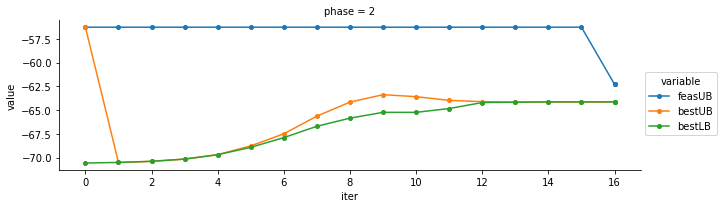

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

xcol = 'iter'
if RELAX_LP:
    df_phase1.loc[:,'phase'] = 1
    df_phase1.loc[:,'feasUB'] = np.nan
    df_phase1.loc[ df_phase1.bestUB>1e6,'bestUB'] = np.nan

df_phase2.loc[:,'phase'] = 2
df_phase2.loc[ df_phase2.feasUB>1e6,'feasUB'] = np.nan
if RELAX_LP:
    dsplot = pd.concat([df_phase1, df_phase2])
else:
    dsplot = df_phase2
dsplot = dsplot[[xcol,'feasUB','bestUB','bestLB','phase']]
dsplot = dsplot.melt(id_vars=[xcol,'phase'])

g = sns.FacetGrid(dsplot, hue='variable', size=3, aspect=3, row='phase', sharey=False)
g.map(plt.plot, xcol,'value', marker='o', markersize=4)
g.add_legend()

In [14]:
objfun = master.model.getObjective()

In [15]:
for i in [10, 100]: #, 1000, 10000]:
    cons = master.model.getConstrs()[i]
    print("%s %s %s" % (master.model.getRow(cons), cons.Sense, cons.RHS))

<gurobi.LinExpr: tk_scen_19 + u_80 + 5.0 u_81> < -56.5
<gurobi.LinExpr: tk_scen_24 + 3.0 u_981> < -54.0


for i in range(len(master.model.getConstrs())):
    cons = master.model.getConstrs()[i]
    print("%s %s %s" % (master.model.getRow(cons), cons.Sense, cons.RHS))